# Gcastle

2024-01-22 10:59:12,466 - /home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-01-22 10:59:12,469 - /home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/castle/algorithms/gradient/pnl/torch/pnl.py[line:135] - INFO: GPU is unavailable.


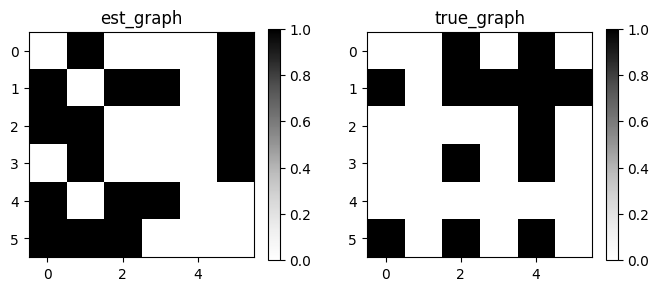

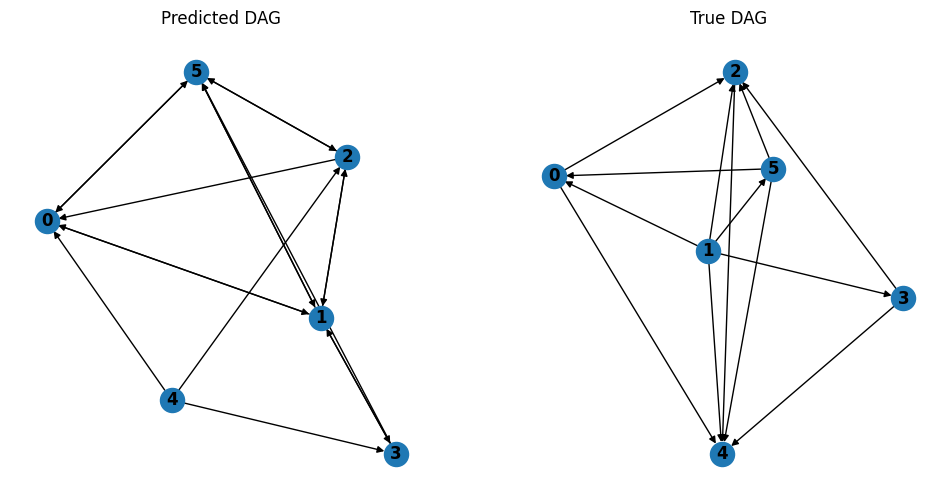

{'fdr': 0.4545, 'tpr': 0.4615, 'fpr': 2.5, 'shd': 8, 'nnz': 11, 'precision': 0.3529, 'recall': 0.4615, 'F1': 0.4, 'gscore': 0.0}


/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [7]:
# Gcastle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import PNL
import networkx as nx
import matplotlib.pyplot as plt


method = "nonlinear"
sem_type = "gp"
n_nodes = 6
n_edges = 15
n = 300

# simulation for pc
weighted_random_dag = DAG.erdos_renyi(
    n_nodes=n_nodes, n_edges=n_edges, weight_range=(0.5, 2.0), seed=1
)
dataset = IIDSimulation(W=weighted_random_dag, n=n, method=method, sem_type=sem_type)
true_dag, X = dataset.B, dataset.X

pc = PNL(device_type="cpu")
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_dag)

# Convert matrices to NetworkX graph objects
predict_graph = nx.DiGraph(pc.causal_matrix, create_using=nx.DiGraph())
true_graph = nx.DiGraph(true_dag, create_using=nx.DiGraph())

# Plot the graphs
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.title("Predicted DAG")
nx.draw(predict_graph, with_labels=True, font_weight="bold")

plt.subplot(122)
plt.title("True DAG")
nx.draw(true_graph, with_labels=True, font_weight="bold")

plt.show()


# calculate accuracy
met = MetricsDAG(pc.causal_matrix, true_dag)
print(met.metrics)

In [11]:
dataset.X.shape

(300, 6)

In [12]:
weighted_random_dag

array([[-0.   , -0.   , -1.505, -0.   , -1.769, -0.   ],
       [ 1.287, -0.   ,  0.844, -1.302,  1.871,  1.186],
       [-0.   ,  0.   ,  0.   ,  0.   ,  1.704, -0.   ],
       [-0.   ,  0.   ,  1.744, -0.   ,  0.91 ,  0.   ],
       [-0.   , -0.   ,  0.   , -0.   ,  0.   ,  0.   ],
       [-0.713,  0.   , -1.119,  0.   ,  1.436, -0.   ]])

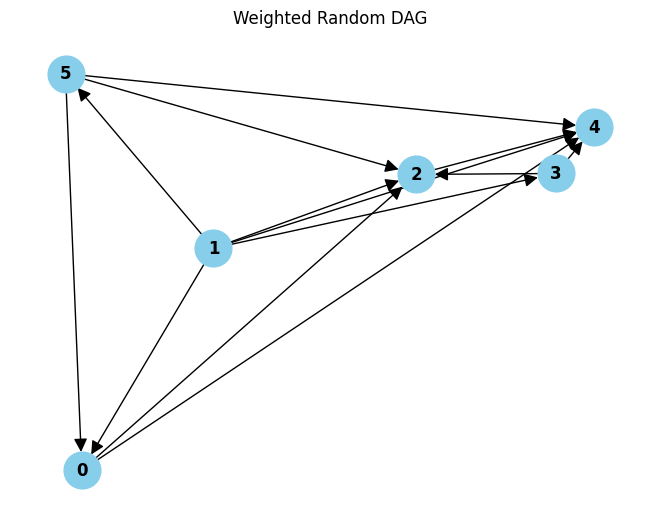

In [13]:
dag_graph = nx.DiGraph(weighted_random_dag)

pos = nx.spring_layout(dag_graph)
nx.draw(
    dag_graph,
    pos,
    with_labels=True,
    font_weight="bold",
    node_size=700,
    node_color="skyblue",
    arrowsize=20,
)

plt.title("Weighted Random DAG")
plt.show()

In [51]:
import os
import json
import re
import pandas as pd


def extract_information_from_filename(filename):
    with open(filename, "r") as file:
        data = json.load(file)

    match = re.match(
        r"evaluation_results_chunk_(\d+)_ratio_(\d+)_quesitons_(\w+)", filename
    )
    if match:
        chunk_size = int(match.group(1))
        document_ratio = int(match.group(2))
        question_list_name = match.group(3)
    else:
        chunk_size = None
        document_ratio = None
        question_list_name = None

    return data, chunk_size, document_ratio, question_list_name


folder_path = "../temp/"
json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]

data_list = []

for filename in json_files:
    filepath = os.path.join(folder_path, filename)
    (
        data,
        chunk_size,
        document_ratio,
        question_list_name,
    ) = extract_information_from_filename(filepath)

    value_list = [
        data["overall"]["average_response_time"],
        data["overall"]["average_faithfulness"],
        data["overall"]["average_relevancy"],
        data["overall"]["average_bleu_score"],
        data["overall"]["average_rouge_l_score"],
        data["overall"]["Question List Name"],
        data["overall"]["Chunk Size"],
        data["overall"]["Document Ratio"],
        data.get("Q1", None),
        data.get("Q2", None),
        data.get("Q3", None),
    ]

    row_data = {
        "average_response_time": value_list[0],
        "average_faithfulness": value_list[1],
        "average_relevancy": value_list[2],
        "average_bleu_score": value_list[3],
        "average_rouge_l_score": value_list[4],
        "Question List Name": value_list[5],
        "Chunk Size": value_list[6],
        "Document Ratio": value_list[7],
        "Q1": value_list[8],
        "Q2": value_list[9],
        "Q3": value_list[10],
    }

    data_list.append(row_data)

df = pd.DataFrame(data_list)

In [52]:
df["Question List Name"].value_counts()

Question List Name
eval_questions                                  16
reorder_question_simplified_list                16
reorder_question_without_question_words_list    16
Name: count, dtype: int64

In [53]:
df.to_csv("../../resource/data/GC/result_causal_testing.csv")
df = df.drop(["Q1", "Q2", "Q3"], axis=1)
df["Instruction existence"] = df["Question List Name"].apply(
    lambda x: 1 if x == "eval_questions" else 0
)

,average_response_time,average_faithfulness,average_relevancy,average_bleu_score,average_rouge_l_score,Question List Name,Chunk Size,Document Ratio,Instruction existence
0,3.260934,0.000000,0.000000,3.143085e-02,1.077147,eval_questions,512,0,1
1,5.481938,0.666667,0.666667,9.671030e-232,1.333751,reorder_question_simplified_list,2048,1,0
2,4.977901,0.666667,0.666667,9.681608e-232,1.333888,reorder_question_simplified_list,1536,1,0
3,2.745893,0.666667,0.333333,3.014522e-02,1.124904,eval_questions,512,1,1
4,4.492589,0.000000,0.333333,2.269095e-155,1.255168,reorder_question_simplified_list,2048,0,0
5,3.629058,0.666667,0.666667,8.851184e-232,1.272885,eval_questions,1536,1,1
6,2.688584,0.000000,0.000000,5.445490e-02,1.092523,eval_questions,256,1,1
7,5.552754,1.000000,0.666667,5.303928e-02,1.245628,reorder_question_simplified_list,1792,1,0
8,3.172183,1.000000,0.333333,5.130925e-232,1.303766,eval_questions,1280,1,1
9,2.796847,0.000000,0.000000,3.143085e-02,1.091769,eval_questions,1280,0,1


In [54]:
df = df.drop(["Question List Name"], axis=1)

In [56]:
data = df.to_numpy()

In [59]:
data.shape

(48, 8)

## Build the causal graph

In [101]:
def plot_dag(graph, labels_node):
    pos = nx.spring_layout(graph)

    i = 0
    node_values = {}
    for node in graph.nodes:
        node_values[node] = labels_node[i]
        i = i + 1

    edge_weights = [graph.edges[edge]["weight"] for edge in graph.edges]

    node_size_factor = 100
    node_sizes = [node_size_factor * len(label) for label in labels_node]

    font_size = 8

    plt.figure(figsize=(20, 12))

    nx.draw_networkx_labels(
        graph,
        pos,
        labels=node_values,
        font_weight="bold",
        font_color="black",
        font_size=font_size,
    )
    edge_labels = {
        (edge[0], edge[1]): f"{graph.edges[edge]['weight']:.2f}" for edge in graph.edges
    }
    nx.draw_networkx_edge_labels(
        graph, pos, edge_labels=edge_labels, font_color="green"
    )
    nx.draw_networkx_edges(
        graph,
        pos,
        width=edge_weights,
        edge_color="gray",
        alpha=0.7,
        arrowsize=50,
        connectionstyle="arc3,rad=0.1",
    )
    nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color="Green")

    plt.title("Directed Acyclic Graph")
    plt.show()

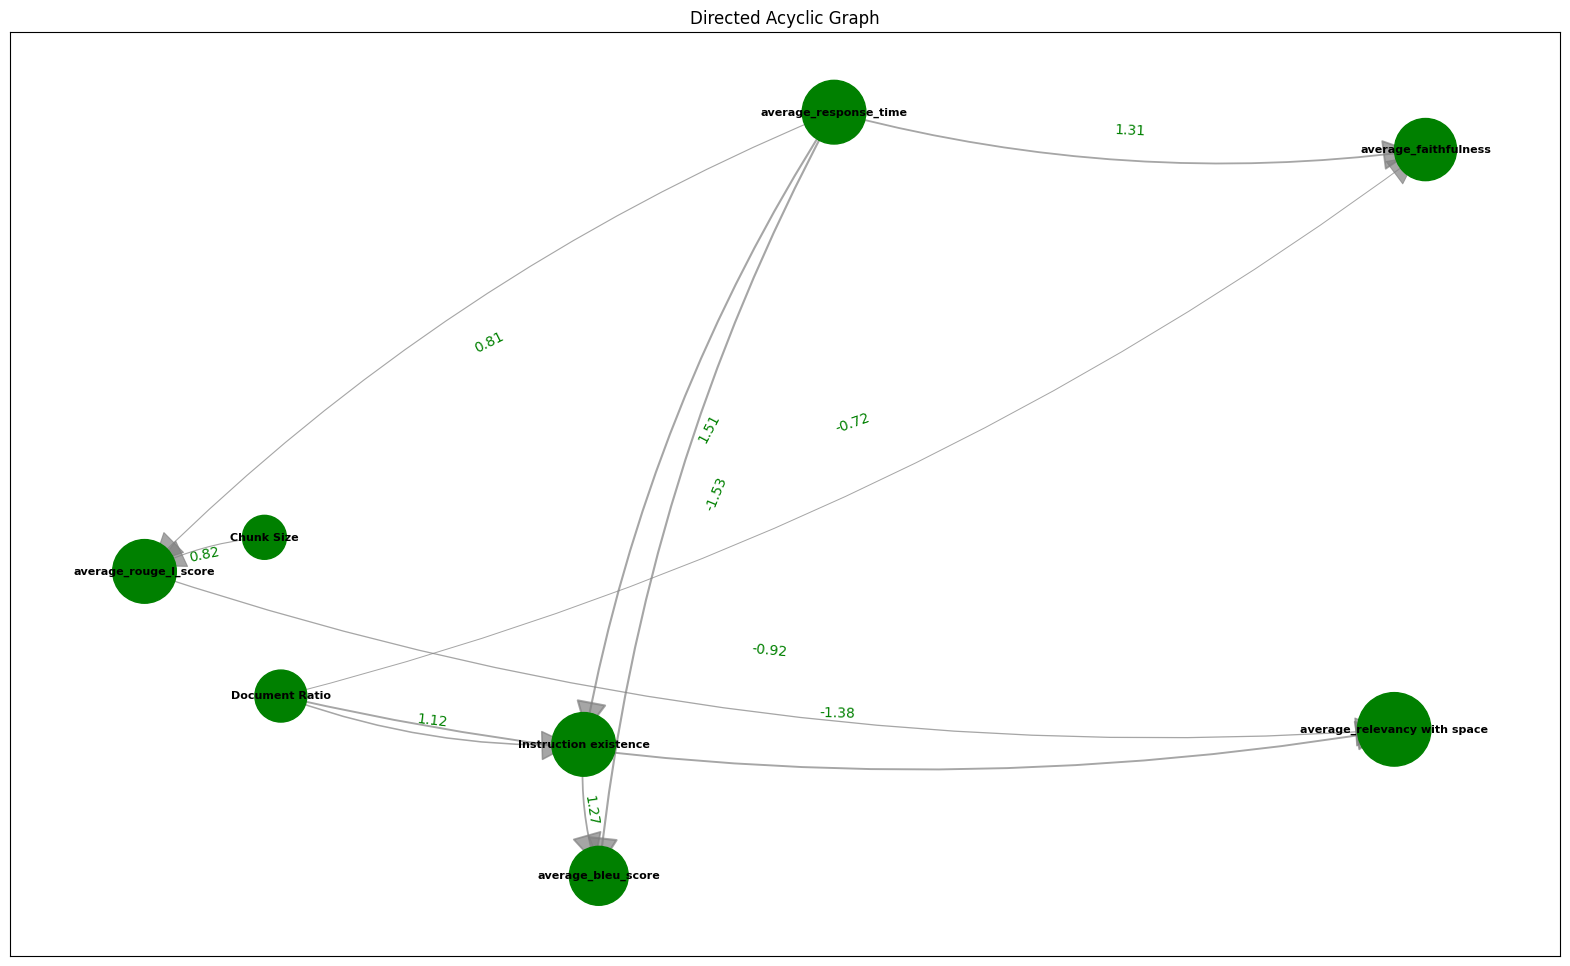

In [108]:
n_nodes = 8
n_edges = 8
weighted_random_dag = DAG.erdos_renyi(
    n_nodes=n_nodes, n_edges=n_edges, weight_range=(0.5, 2.0), seed=1
)
dag_graph = nx.DiGraph(weighted_random_dag)
labels_node = [
    "average_response_time",
    "average_faithfulness",
    "average_relevancy with space",
    "average_bleu_score",
    "average_rouge_l_score",
    "Chunk Size",
    "Document Ratio",
    "Instruction existence",
]
plot_dag(dag_graph, labels_node)

PC constrain based

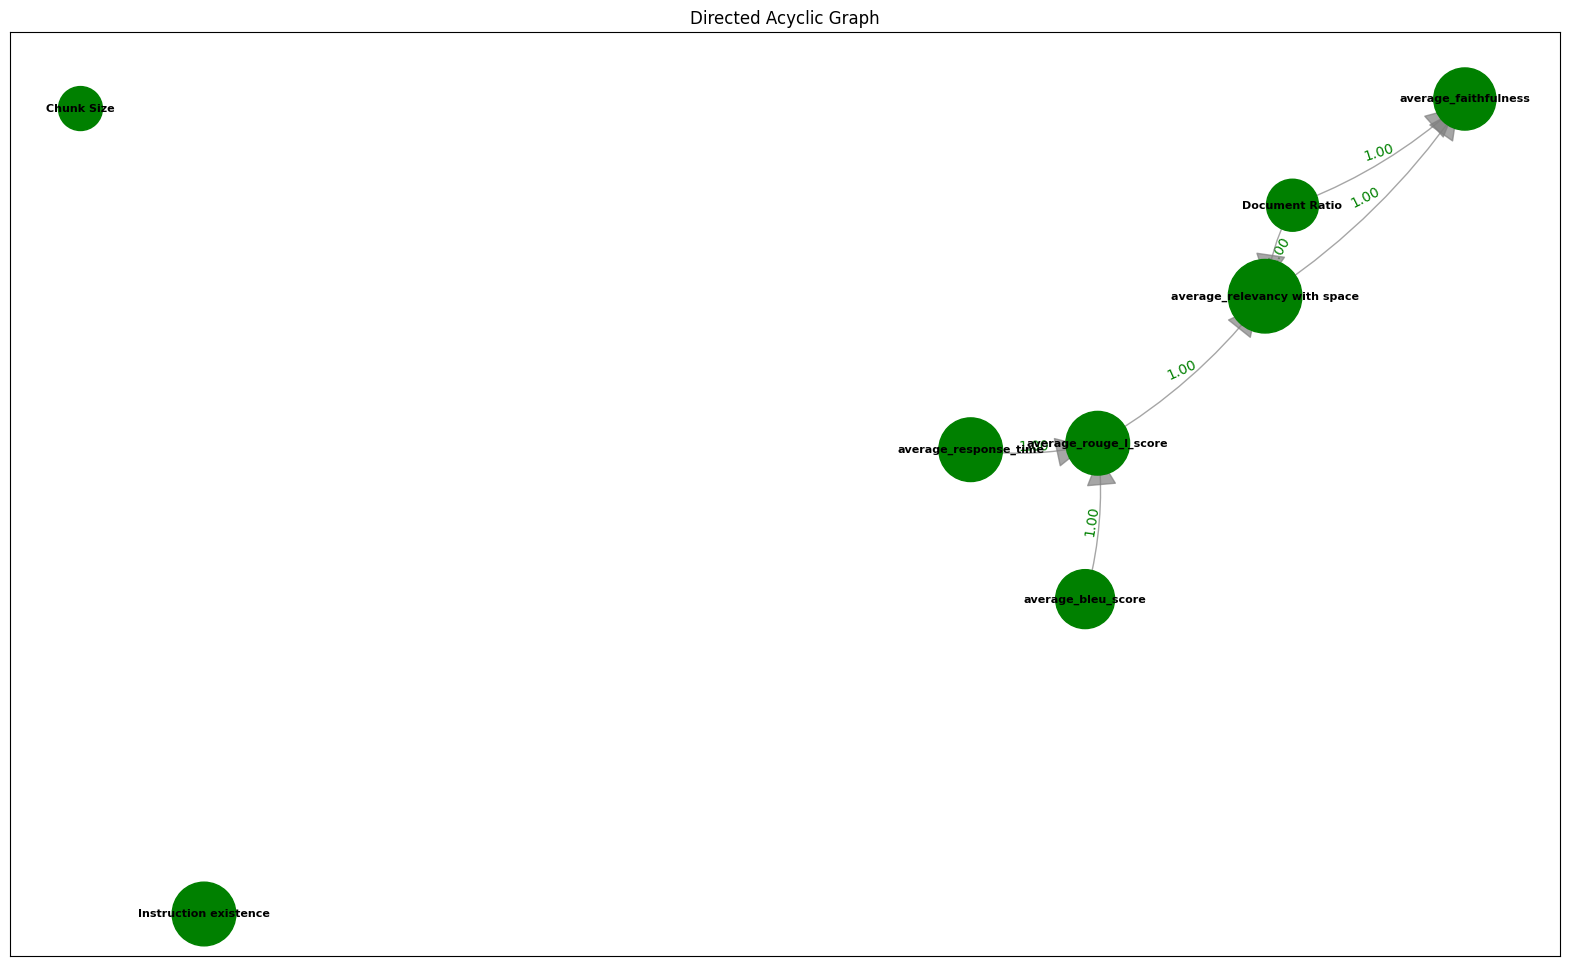

In [121]:
# PC constrain based
from castle.algorithms import DirectLiNGAM
from castle.datasets import load_dataset
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import load_dataset
from castle.algorithms import PC
from castle.algorithms.gradient.dag_gnn.torch import DAG_GNN

pc = PC()
pc.learn(data)
predict_graph = nx.DiGraph(pc.causal_matrix, create_using=nx.DiGraph())
labels_node = [
    "average_response_time",
    "average_faithfulness",
    "average_relevancy with space",
    "average_bleu_score",
    "average_rouge_l_score",
    "Chunk Size",
    "Document Ratio",
    "Instruction existence",
]
plot_dag(predict_graph, labels_node)

Post-Nonlinear Causal Model - Function based

2024-01-22 16:10:01,127 - /home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/castle/algorithms/gradient/pnl/torch/pnl.py[line:135] - INFO: GPU is unavailable.


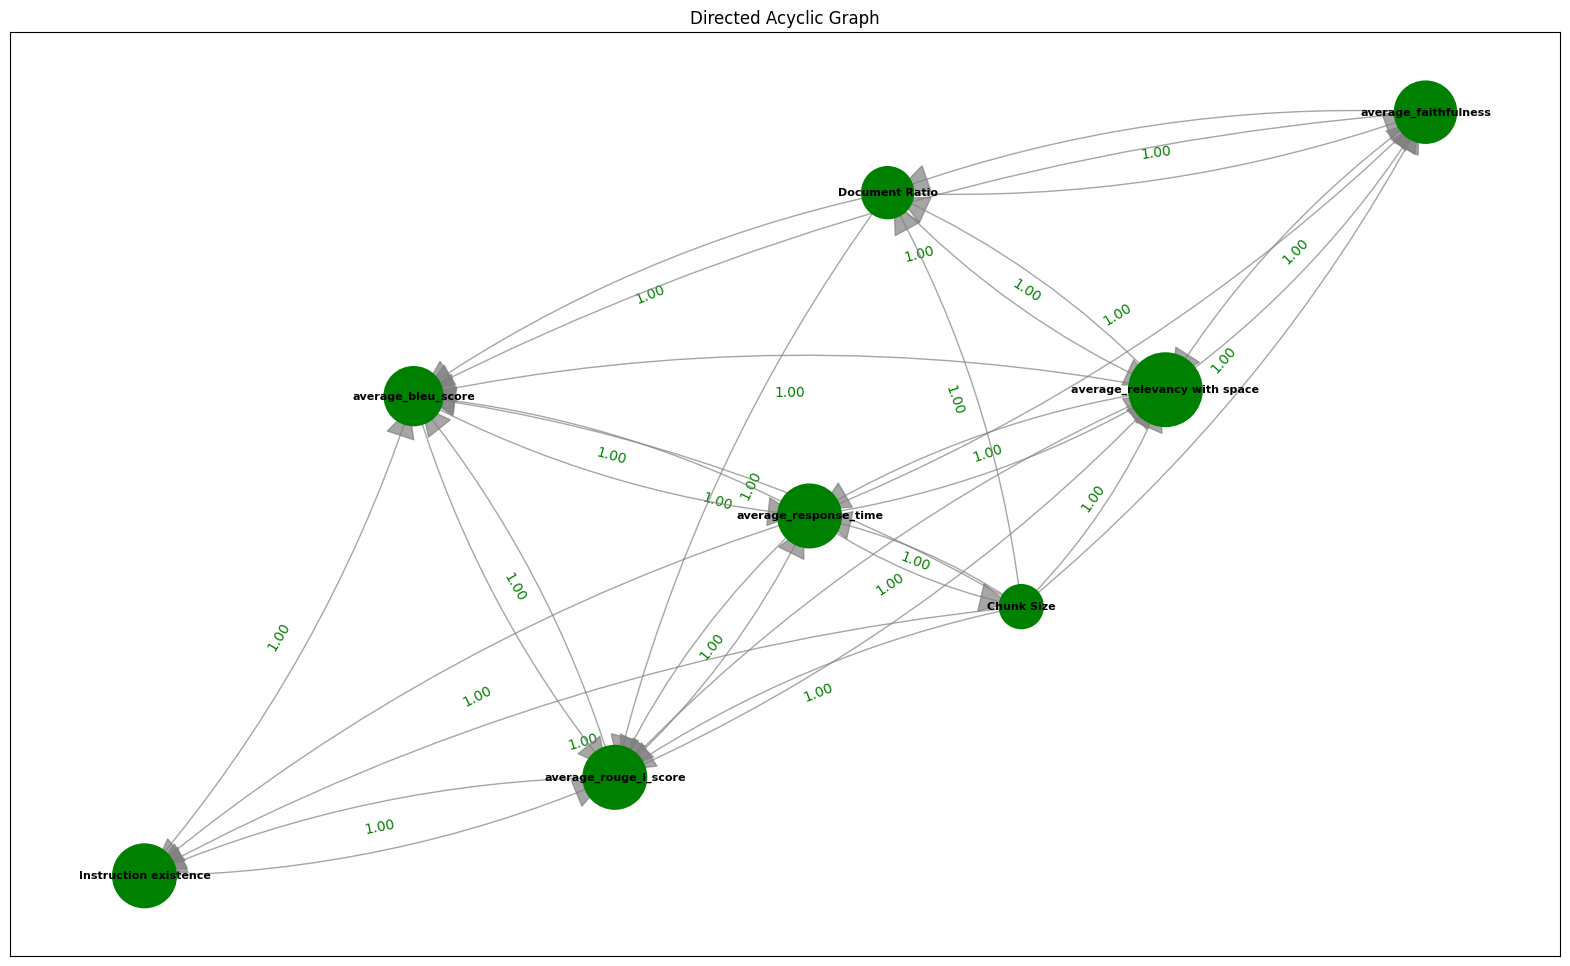

In [114]:
# Post-Nonlinear Causal Model
pnl = PNL(device_type="cpu")
pnl.learn(data)
predict_graph = nx.DiGraph(pnl.causal_matrix, create_using=nx.DiGraph())
labels_node = [
    "average_response_time",
    "average_faithfulness",
    "average_relevancy with space",
    "average_bleu_score",
    "average_rouge_l_score",
    "Chunk Size",
    "Document Ratio",
    "Instruction existence",
]
plot_dag(predict_graph, labels_node)

Gradien based GNN - Gradient-based


2024-01-22 16:15:46,558 - /home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:167] - INFO: GPU is unavailable.
2024-01-22 16:15:47,200 - /home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 1.5197147509074806
2024-01-22 16:15:49,758 - /home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 1.5117067119126357
2024-01-22 16:15:50,309 - /home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 1.5117067119126357
2024-01-22 16:15:50,940 - /home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 3, epoch: 299, h_new: 1.5117

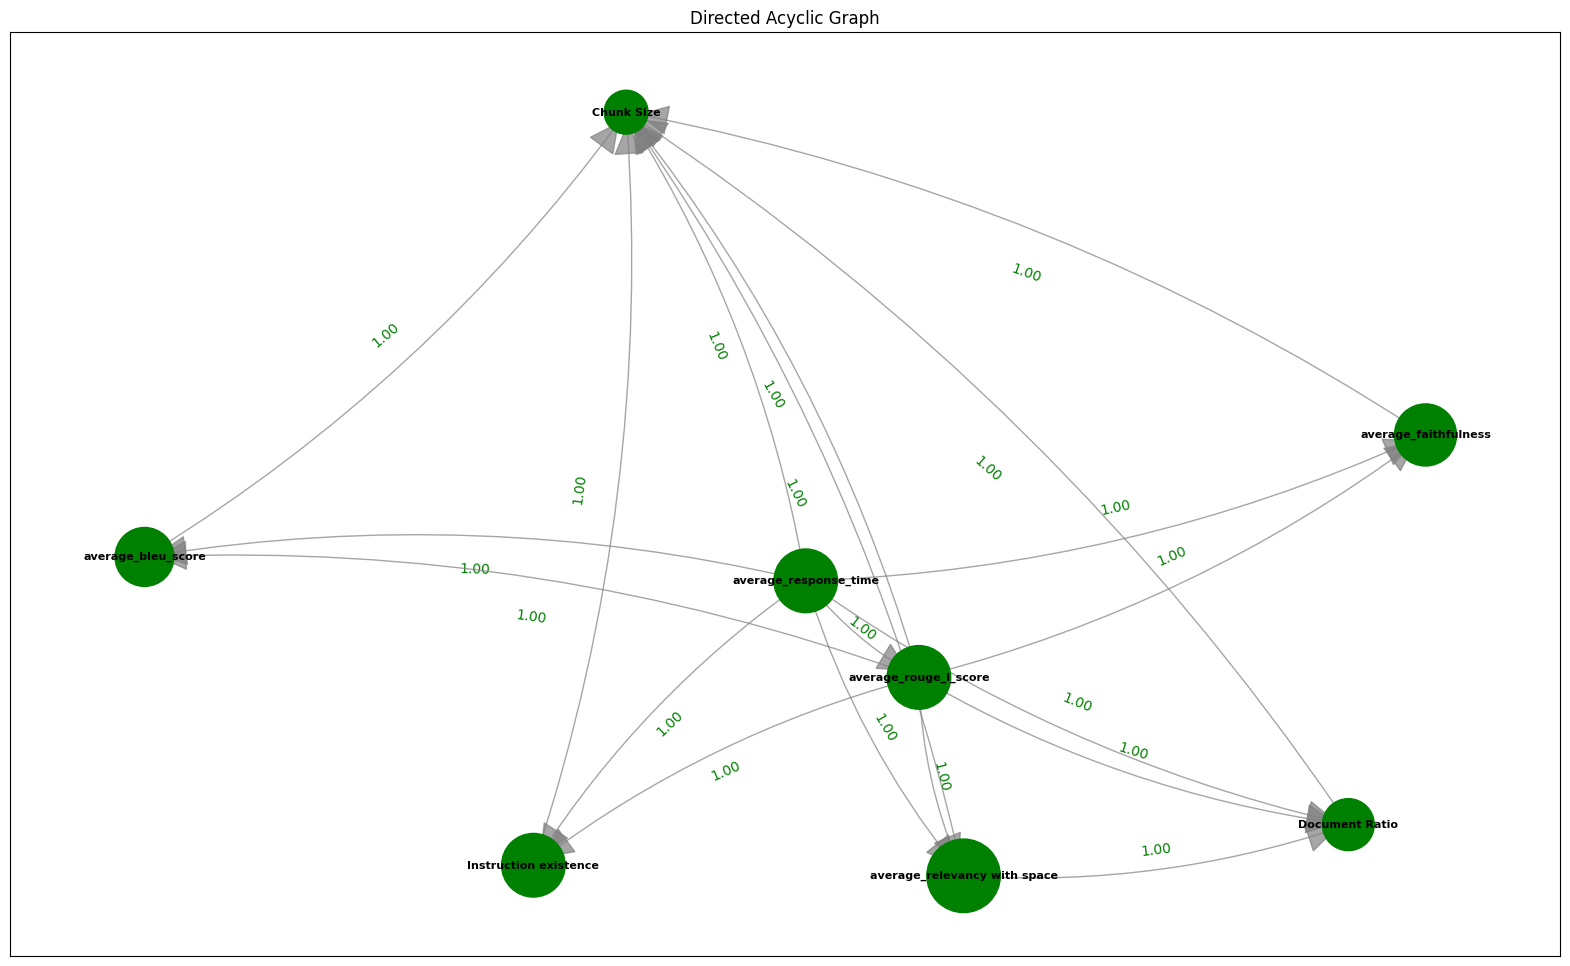

In [115]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import DAG_GNN

gnn = DAG_GNN()
gnn.learn(data)
predict_graph = nx.DiGraph(gnn.causal_matrix, create_using=nx.DiGraph())
labels_node = [
    "average_response_time",
    "average_faithfulness",
    "average_relevancy with space",
    "average_bleu_score",
    "average_rouge_l_score",
    "Chunk Size",
    "Document Ratio",
    "Instruction existence",
]
plot_dag(predict_graph, labels_node)

Score Based

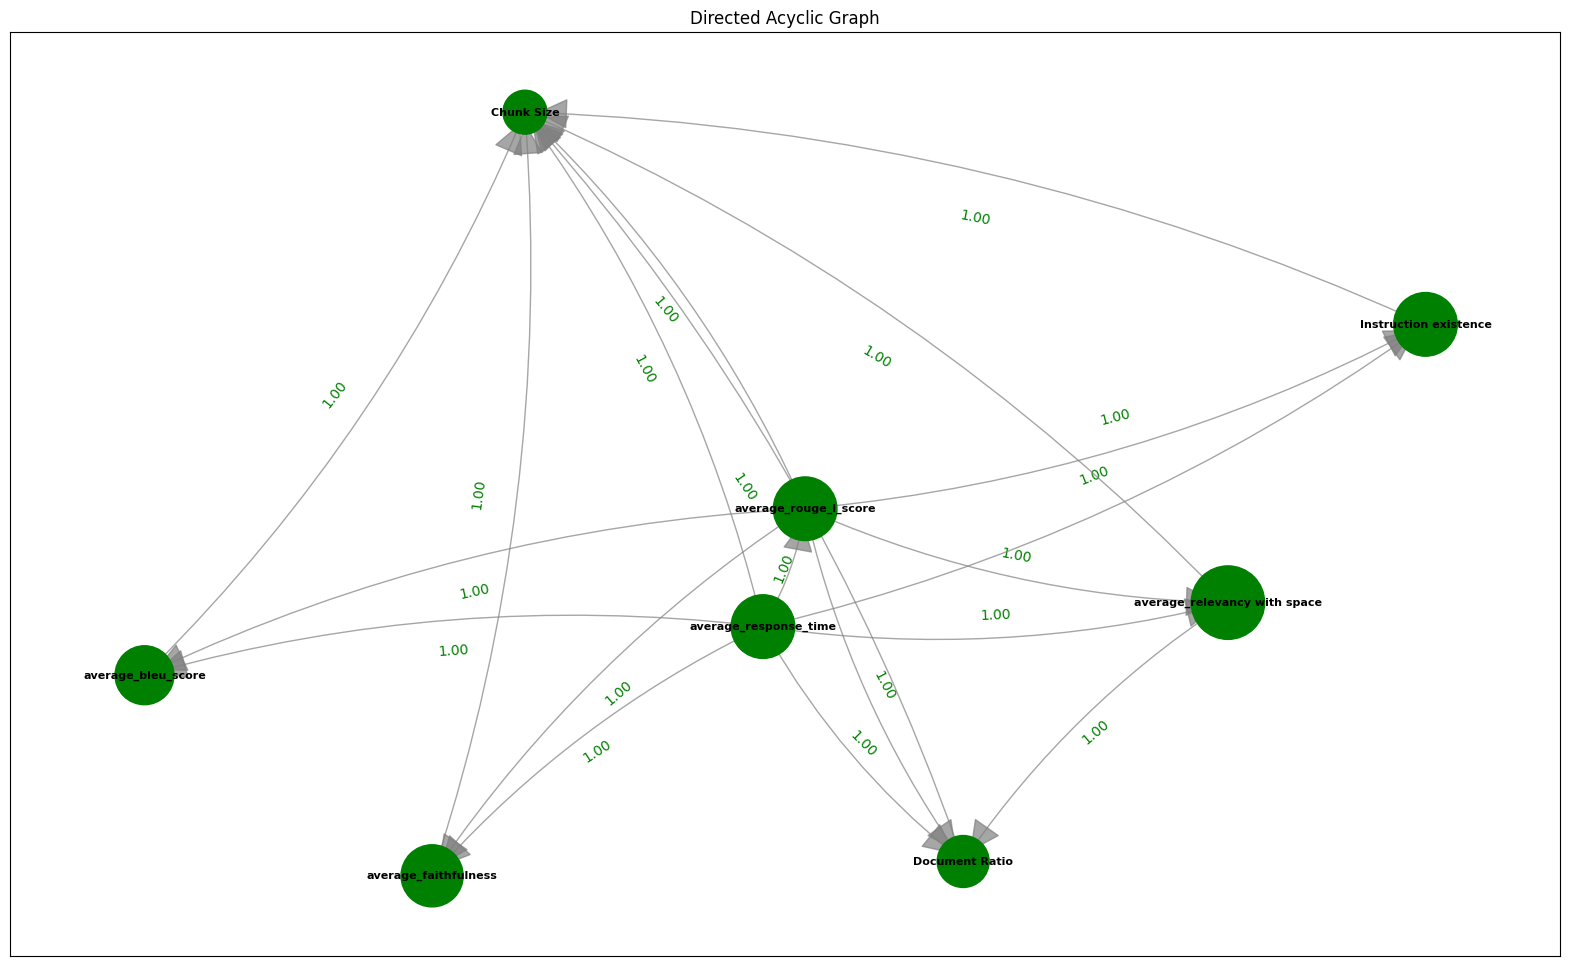

In [120]:
from castle.datasets import DAG, IIDSimulation
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.algorithms.ges.ges import GES


algo = GES(criterion="bic", method="scatter")
algo.learn(data)
predict_graph = nx.DiGraph(gnn.causal_matrix, create_using=nx.DiGraph())
labels_node = [
    "average_response_time",
    "average_faithfulness",
    "average_relevancy with space",
    "average_bleu_score",
    "average_rouge_l_score",
    "Chunk Size",
    "Document Ratio",
    "Instruction existence",
]
plot_dag(predict_graph, labels_node)

In [122]:
data

array([[3.261e+000, 0.000e+000, 0.000e+000, 3.143e-002, 1.077e+000,
        5.120e+002, 0.000e+000, 1.000e+000],
       [5.482e+000, 6.667e-001, 6.667e-001, 9.671e-232, 1.334e+000,
        2.048e+003, 1.000e+000, 0.000e+000],
       [4.978e+000, 6.667e-001, 6.667e-001, 9.682e-232, 1.334e+000,
        1.536e+003, 1.000e+000, 0.000e+000],
       [2.746e+000, 6.667e-001, 3.333e-001, 3.015e-002, 1.125e+000,
        5.120e+002, 1.000e+000, 1.000e+000],
       [4.493e+000, 0.000e+000, 3.333e-001, 2.269e-155, 1.255e+000,
        2.048e+003, 0.000e+000, 0.000e+000],
       [3.629e+000, 6.667e-001, 6.667e-001, 8.851e-232, 1.273e+000,
        1.536e+003, 1.000e+000, 1.000e+000],
       [2.689e+000, 0.000e+000, 0.000e+000, 5.445e-002, 1.093e+000,
        2.560e+002, 1.000e+000, 1.000e+000],
       [5.553e+000, 1.000e+000, 6.667e-001, 5.304e-002, 1.246e+000,
        1.792e+003, 1.000e+000, 0.000e+000],
       [3.172e+000, 1.000e+000, 3.333e-001, 5.131e-232, 1.304e+000,
        1.280e+003, 1.000e+0